## General info
Dates of interest

* 01/06/2015
* 01/27/2015
* 12/11/2014

Timeframes of interest : Between 4 and 6 PM (but should still consider the entire day)

Keywords: JPMorgan, wire, transfer

## Mounting the image
Mounting the image read-only with NTFS specific parameters

In [ ]:
mount -o ro,loop,show_sys_files,streams_interface=windows /mnt/hgfs/ssd/039533.001 /mnt/usb/

## Creating timeline
Used 'log2timeline' from SANS SIFT VM
Image local time is set to CET (Paris time)
Output format set to CSV

In [ ]:
log2timeline -z CET -r -p -f win7 -o csv -w /cases/bodyfile /mnt/usb

## Analyzing the timeline using Apache Spark
Timeline analysis can be difficult and very time consuming if the CSV files are too large, or if we have multiple images to go through.

Spark can make that job much easier and more efficient.

In [ ]:
# Create a Spark SQL context
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# Load CSV files into a Spark DataFrame
df = sqlContext.load(source="com.databricks.spark.csv", header="true", path = "/user/cloudera/bodyfile")

In [99]:
# Count the number of rows in the DataFrame and the schema from the CSV
df.printSchema()
df.count()

root
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- timezone: string (nullable = true)
 |-- MACB: string (nullable = true)
 |-- source: string (nullable = true)
 |-- sourcetype: string (nullable = true)
 |-- type: string (nullable = true)
 |-- user: string (nullable = true)
 |-- host: string (nullable = true)
 |-- short: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- version: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- inode: string (nullable = true)
 |-- notes: string (nullable = true)
 |-- format: string (nullable = true)
 |-- extra: string (nullable = true)



1322918L

In [ ]:
# This displays the DataFrame's column names based on the CSV header
df.columns

In [ ]:
# Register the DataFrame as a Spark SQL table called 'tl' so we can run queries using SQL syntax
sqlContext.registerDataFrameAsTable(df, 'tl')
# Cache the table in memory for faster lookups
sqlContext.cacheTable('tl')

#RDD Name	Storage Level	Cached Partitions	Fraction Cached	Size in Memory	Size in Tachyon	Size on Disk
#In-memory table tl	Memory Deserialized 1x Replicated	5	100%	286.2 MB	0.0 B	0.0 B

### Keyword search
#### Did the user execute any files that seem potentially malicious?

In [92]:
# Collect all the rows into a Python list that only contains rows matching certain conditions
filtered = sqlContext.sql("select * from tl where `date` like '01/%/2015' and short like '%wire%'").collect()

# Print out the results
for i in filtered:
    print i.date+" "+i.time+" "+i.source+" "+i.MACB+" "+i.short+" "+i.desc

01/28/2015 11:54:42 FILE MAC. /Users/user.name/AppData/Local/Temp/Temp1_wire_tr91297.zip /Users/user.name/AppData/Local/Temp/Temp1_wire_tr91297.zip
01/27/2015 16:29:25 FILE ...B /Users/user.name/AppData/Local/Temp/Temp1_wire_tr91297.zip /Users/user.name/AppData/Local/Temp/Temp1_wire_tr91297.zip
01/27/2015 16:29:38 REG MACB C:/Users/user.name/AppData/Local/Temp/Temp1_wire_tr91297.zip/wire_tr91297_pdf.exe C:/Users/user.name/AppData/Local/Temp/Temp1_wire_tr91297.zip/wire_tr91297_pdf.exe [Count: 0]  nr. of times app had focus: 0 and duration of focus: 0ms
01/27/2015 16:30:08 REG MACB CMI-CreateHive{199DAFC2-6F16-4946-BF90-5A3FC3A60902}/Wow6432Node/Microsoft/Tracing/wire_tr91297_pdf_RASAPI32  Key name: HKLM/SoftwareCMI-CreateHive{199DAFC2-6F16-4946-BF90-5A3FC3A60902}/Wow6432Node/Microsoft/Tracing/wire_tr91297_pdf_RASAPI32 
01/27/2015 16:30:08 REG MACB CMI-CreateHive{199DAFC2-6F16-4946-BF90-5A3FC3A60902}/Wow6432Node/Microsoft/Tracing/wire_tr91297_pdf_RASMANCS  Key name: HKLM/SoftwareCMI-Crea

- On 01/27/2015 the user appears to have executed a file named wire_tr91297_pdf.exe that was compressed as a ZIP file (Temp1_wire_tr91297.zip)
- It was not possible to recover the file from the file-system
- It would be reasonable to conclude this file was malware
- We can be certain the malware was executed, but it is unclear whether it continued to run normally

## System activity: Deleted files

###On which dates were files deleted the most?

In [89]:
deletedFilesDF = sqlContext.sql("SELECT `date`, short FROM tl WHERE `date` LIKE '%/%/2015' AND short LIKE '%DELETED%'")
deletedFilesRowList = deletedFilesDF.collect()

In [90]:
deletedFileListDate = []
deletedFileList = []
for deletedFile in deletedFilesRowList:
    deletedFileListDate.append(deletedFile.date)
    deletedFileList.append(deletedFile.short)

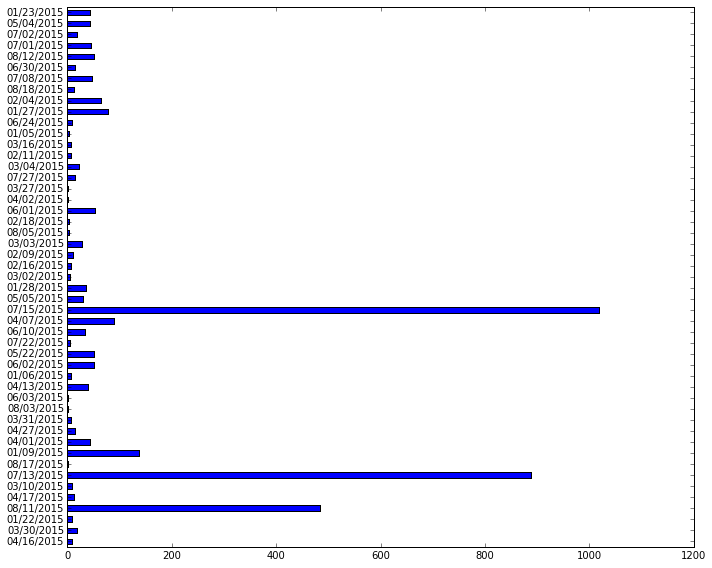

In [91]:
import pandas as pd
from collections import Counter
dates = Counter(deletedFileListDate)
counts = dates
index = []
data = []

for k,v in counts.iteritems():
    index.append(k)
    data.append(v)
ts = pd.TimeSeries(data, index)
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='r')
ts.plot(kind="barh")

#### Display the files that were deleted
( limited it to 10 results to avoid bloating the notebook with results )

In [114]:
i = 0
for file in deletedFilesRowList:
        if file.date == '07/15/2015' or file.date == '07/13/2015' or file.date == '08/11/2015':
            if i < 10:
                print file
            i=i+1

Row(date=u'07/13/2015', short=u'DELETED C:/Users/user.name/AppData/Local/Microsoft/Windows/Temporary Internet Files/Content.IE5/J89JEAZT/xlviewerinternal[2].htm')
Row(date=u'07/13/2015', short=u'DELETED C:/Users/user.name/AppData/Local/Microsoft/Windows/Temporary Internet Files/Content.IE5/J89JEAZT/ga[1].js')
Row(date=u'07/15/2015', short=u'DELETED C:/Users/user.name/AppData/Local/Microsoft/Windows/Temporary Internet Files/Content.IE5/8MB82JIU/seg[7].htm')
Row(date=u'07/15/2015', short=u'DELETED C:/Users/user.name/AppData/Local/Microsoft/Windows/Temporary Internet Files/Content.IE5/8MB82JIU/ddc[1].htm')
Row(date=u'07/15/2015', short=u'DELETED C:/Users/user.name/AppData/Local/Microsoft/Windows/Temporary Internet Files/Content.IE5/8MB82JIU/comboCAJVJJYC.js')
Row(date=u'07/15/2015', short=u'DELETED C:/Users/user.name/AppData/Local/Microsoft/Windows/Temporary Internet Files/Content.IE5/8MB82JIU/ctn[2].js')
Row(date=u'07/13/2015', short=u'DELETED C:/Users/user.name/AppData/Local/Microsoft/W

- On 07/15/2015 and 07/13/2015 the user deleted browisng history
- On 08/11/2015 an application was uninstalled

### Web history on the dates in question

In [96]:
visitedList = []
myDates = ['12/11/2014', '01/06/2015', '01/27/2015']
for i in myDates:
    webhist = sqlContext.sql("select * from tl where source='WEBHIST' and `date` like '%s' limit 20 " %(i) ).collect()
    for i in webhist:
        visitedList.append(i.date + " " + i.short)

In [115]:
for i in visitedList:
    dateurl = i.split(" ")
    url = dateurl[0] + " " + dateurl[2]
    print url

12/11/2014 DOMStore:http://www.but.fr/
12/11/2014 DOMStore:http://www.ikea.com/
12/11/2014 DOMStore:http://www.conforama.fr/
12/11/2014 DOMStore:http://www.lafourchette.com/
12/11/2014 DOMStore:http://www.fleux.com/
12/11/2014 DOMStore:https://order.cdiscount.com/
12/11/2014 DOMStore:https://cdlc.iadvize.com/
12/11/2014 http://s0.2mdn.net/1785842/BAU_AVEU_FR_0115_728x90_AvisPreferred_3rentals_x_FR.swf
12/11/2014 https://apis.google.com/_/scs/abc-static/_/js/k=gapi.gapi.en.wgbKiK972Ko.O/m=gapi_iframes-googleapis_client-plusone/rt=j/sv=1/d=1/ed=1/rs=AItRSTOlX0YCaQmKijyj5lpKQ5AVm7UE6A/cb=gapi.loaded_0
12/11/2014 fleux.com/
12/11/2014 1281860200.log.optimizely.com/
12/11/2014 lafourchette.d3.sc.omtrdc.net/
12/11/2014 nextag.fr/
12/11/2014 leapfrog.solution.weborama.fr/
12/11/2014 www.lafourchette.com/
12/11/2014 www.fleux.com/
12/11/2014 easyrtg.com/
12/11/2014 www.fly.fr/
12/11/2014 www.laredoute.fr/
12/11/2014 www.laredoute.fr/
01/06/2015 DOMStore:http://www.santemagazine.fr/
01/06/2015 